In [2]:
import torchgeometry as tgm
import torch.utils as utils
import numpy as np
import cv2
import imageio
from pathlib import Path
import torch
from torch import optim
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from tqdm.auto import tqdm
from metrics import dice_score

C:\Users\amin2\anaconda3\envs\teamProjectSeg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)

cuda:0


In [4]:
#image paths
dir_train_x = 'data/training/images/'
label_path = 'data/training/1st_manual/'
dir_test_x = 'data/test/images/'
label_test_path = 'data/test/1st_manual/'
dir_valid_x = 'data/valid/images/'
label_valid_path = 'data/valid/1st_manual/'

images = list()
labels = list()
images_test = list()
labels_test = list()
images_valid = list()
labels_valid = list()

for file in Path(dir_train_x).iterdir():
    if not file.is_file():
        continue
    img_rgb = imageio.v2.imread(file)
    img_real = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
    images.append(img_real)

for file in Path(label_path).iterdir():
    if not file.is_file():
        continue

    img_rgb = imageio.v2.imread(file)
    labels.append(img_rgb)
    
for file in Path(dir_test_x).iterdir():
    if not file.is_file():
        continue
    img_rgb = imageio.v2.imread(file)
    img_two = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
    images_test.append(img_two)

for file in Path(label_test_path).iterdir():
    if not file.is_file():
        continue
    img_rgb = imageio.v2.imread(file)
    labels_test.append(img_rgb)
    
for file in Path(dir_valid_x).iterdir():
    if not file.is_file():
        continue
    img_rgb = imageio.v2.imread(file)
    img_two = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
    images_valid.append(img_two)

for file in Path(label_valid_path).iterdir():
    if not file.is_file():
        continue
    img_rgb = imageio.v2.imread(file)
    labels_valid.append(img_rgb)

def resize(imgs,resize_height, resize_width):
    img_resize = []
    for file in imgs:
        img_resize.append(cv2.resize(file,(resize_height,resize_width)))
    return img_resize

resize_height, resize_width = (512, 512)
imgs = resize(images,resize_height, resize_width)
lbls = resize(labels,resize_height, resize_width)
imgs_test = resize(images_test,resize_height, resize_width)
lbls_test = resize(labels_test,resize_height, resize_width)
imgs_valid = resize(images_valid,resize_height, resize_width)
lbls_valid = resize(labels_valid,resize_height, resize_width)

X_train = np.array(imgs)
Y_train = np.array(lbls)
X_test = np.array(imgs_test)
Y_test = np.array(lbls_test)
X_valid = np.array(imgs_valid)
Y_valid = np.array(lbls_valid)

X_train = X_train.astype('float32')/255
Y_train = Y_train.astype('float32')/255
X_test = X_test.astype('float32')/255
Y_test = Y_test.astype('float32')/255
X_valid = X_valid.astype('float32')/255
Y_valid = Y_valid.astype('float32')/255

print("Pre-processing is finished.")
# train_data = []
# for i in range(len(X_train)):
#    train_data.append([X_train[i], Y_train[i]])

# data_loader_training = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=batchsize)

Pre-processing is finished.


In [5]:
X_train = np.transpose(X_train, (0, 3, 1, 2))
training_set = utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))

X_valid = np.transpose(X_valid, (0, 3, 1, 2))
valid_set = utils.data.TensorDataset(torch.Tensor(X_valid),  torch.Tensor(Y_valid))

X_test = np.transpose(X_test, (0, 3, 1, 2))
test_set = utils.data.TensorDataset(torch.Tensor(X_test),  torch.Tensor(Y_test))

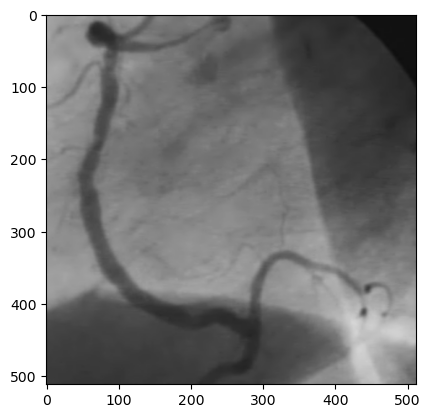

In [6]:
plt.imshow(X_test[10].transpose(1,2,0))

In [7]:
n_classes = 2
Model = smp.EfficientUnetPlusPlus(encoder_name='timm-efficientnet-b0', encoder_weights="imagenet", in_channels=3, classes=n_classes)
Model.to(device)
lr = 0.001
optimizer = optim.Adam(Model.parameters(), lr=lr)
criterion = tgm.losses.TverskyLoss(alpha=0.5, beta=5)
batchsize = 1
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, threshold=0.001, patience = 2)

data_loader_training = torch.utils.data.DataLoader(dataset=training_set, batch_size=batchsize, shuffle=True)
data_loader_valid = torch.utils.data.DataLoader(dataset=valid_set, batch_size=batchsize, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset=test_set, batch_size=batchsize, shuffle=True)

In [8]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

In [11]:
num_epochs = 20
#one example of the validation outputs
outputs = []
outputs_val = []
for epoch in range(num_epochs):
    #perform training loop
    Model.train()
    amount=0
    loss_value = 0
    avg_dice = 0
    loop = tqdm(data_loader_training)
    for (img,label) in loop:
        img, label = img.to(device), label.to(device)
        decoded = Model(img)
        loss = criterion(decoded.to("cpu"), label.type(torch.LongTensor).to("cpu"))
        loss_value += loss.item()
        optimizer.zero_grad()
        loss.backward()
        avg_dice += dice_score(input = decoded, target = label.type(torch.LongTensor).to("cpu").squeeze(1), use_weights=True)
        optimizer.step()
        amount+=1
        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())
    loss_value = loss_value/amount
    avg_dice = avg_dice/amount
    avg_dice = avg_dice.item()
    outputs.append((epoch, loss_value, avg_dice))
    print("Epoch", epoch, "Training loss:", loss_value, "Training dice:",avg_dice )
    #perform valid loop
    Model.eval()
    loss_value = 0
    amount = 0
    loop = tqdm(data_loader_valid)
    
    with torch.no_grad():
        avg_dice = 0
        for (img,label) in loop:
            img, label = img.to(device), label.to(device)
            decoded = Model(img)
            loss = criterion(decoded.to("cpu"), label.type(torch.LongTensor).to("cpu"))
            loss_value += loss.item()
            amount +=1
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())
            avg_dice += dice_score(input = decoded, target = label.type(torch.LongTensor).to("cpu").squeeze(1), use_weights=True)
            
    loss_value = loss_value/amount
    avg_dice = avg_dice/amount
    avg_dice = avg_dice.item()
    scheduler.step(loss_value)    
    outputs_val.append((epoch, loss_value, avg_dice))
    print("Epoch", epoch, "Validation loss:", loss_value, "Validation dice:",avg_dice )   

Epoch [0/20]: 100%|██████████| 110/110 [00:33<00:00,  3.28it/s, loss=0.244] 


Epoch 0 Training loss: 0.12377511046149514 Training dice: 0.7685744166374207


Epoch [0/20]: 100%|██████████| 11/11 [00:01<00:00, 10.99it/s, loss=0.128]


Epoch 0 Validation loss: 0.12152815948833119 Validation dice: 0.7745997905731201


Epoch [1/20]: 100%|██████████| 110/110 [00:33<00:00,  3.29it/s, loss=0.0734]


Epoch 1 Training loss: 0.1185562252998352 Training dice: 0.7782036066055298


Epoch [1/20]: 100%|██████████| 11/11 [00:00<00:00, 11.36it/s, loss=0.109]


Epoch 1 Validation loss: 0.11946586045351895 Validation dice: 0.7885175347328186


Epoch [2/20]: 100%|██████████| 110/110 [00:33<00:00,  3.27it/s, loss=0.278] 


Epoch 2 Training loss: 0.11763549663803795 Training dice: 0.7801238894462585


Epoch [2/20]: 100%|██████████| 11/11 [00:00<00:00, 11.39it/s, loss=0.0624]


Epoch 2 Validation loss: 0.11516724933277477 Validation dice: 0.7955894470214844


Epoch [3/20]: 100%|██████████| 110/110 [00:33<00:00,  3.31it/s, loss=0.0872]


Epoch 3 Training loss: 0.11403796672821045 Training dice: 0.7857548594474792


Epoch [3/20]: 100%|██████████| 11/11 [00:00<00:00, 11.40it/s, loss=0.118]


Epoch 3 Validation loss: 0.10658232732252641 Validation dice: 0.8220226168632507


Epoch [4/20]: 100%|██████████| 110/110 [00:33<00:00,  3.27it/s, loss=0.267] 


Epoch 4 Training loss: 0.10964554060589184 Training dice: 0.7940841913223267


Epoch [4/20]: 100%|██████████| 11/11 [00:01<00:00, 10.89it/s, loss=0.094]


Epoch 4 Validation loss: 0.11459275809201327 Validation dice: 0.8003117442131042


Epoch [5/20]: 100%|██████████| 110/110 [00:33<00:00,  3.28it/s, loss=0.0779]


Epoch 5 Training loss: 0.10846195437691429 Training dice: 0.7953000664710999


Epoch [5/20]: 100%|██████████| 11/11 [00:01<00:00, 10.55it/s, loss=0.112] 


Epoch 5 Validation loss: 0.10921975699338046 Validation dice: 0.8133399486541748


Epoch [6/20]: 100%|██████████| 110/110 [00:33<00:00,  3.26it/s, loss=0.109] 


Epoch 6 Training loss: 0.10340422608635642 Training dice: 0.8041993379592896


Epoch [6/20]: 100%|██████████| 11/11 [00:00<00:00, 11.23it/s, loss=0.0602]


Epoch 6 Validation loss: 0.1147117398001931 Validation dice: 0.7984906435012817


Epoch [7/20]: 100%|██████████| 110/110 [00:33<00:00,  3.25it/s, loss=0.0583]


Epoch 7 Training loss: 0.09785065434195779 Training dice: 0.8156855702400208


Epoch [7/20]: 100%|██████████| 11/11 [00:00<00:00, 11.40it/s, loss=0.186]


Epoch 7 Validation loss: 0.11072272062301636 Validation dice: 0.8076589703559875


Epoch [8/20]: 100%|██████████| 110/110 [00:33<00:00,  3.28it/s, loss=0.0862]


Epoch 8 Training loss: 0.09383343783291903 Training dice: 0.8218483924865723


Epoch [8/20]: 100%|██████████| 11/11 [00:00<00:00, 11.52it/s, loss=0.104] 


Epoch 8 Validation loss: 0.11180956797166304 Validation dice: 0.8057387471199036


Epoch [9/20]: 100%|██████████| 110/110 [00:34<00:00,  3.20it/s, loss=0.0768]


Epoch 9 Training loss: 0.09156298583204096 Training dice: 0.825696587562561


Epoch [9/20]: 100%|██████████| 11/11 [00:01<00:00, 11.00it/s, loss=0.183]


Epoch 9 Validation loss: 0.11338632215153087 Validation dice: 0.7974042296409607


Epoch [10/20]: 100%|██████████| 110/110 [00:33<00:00,  3.24it/s, loss=0.0563]


Epoch 10 Training loss: 0.08979591889814897 Training dice: 0.8278428316116333


Epoch [10/20]: 100%|██████████| 11/11 [00:01<00:00, 10.81it/s, loss=0.0962]


Epoch 10 Validation loss: 0.11487323045730591 Validation dice: 0.7943337559700012


Epoch [11/20]: 100%|██████████| 110/110 [00:33<00:00,  3.27it/s, loss=0.0475]


Epoch 11 Training loss: 0.0897347011349418 Training dice: 0.8280243277549744


Epoch [11/20]: 100%|██████████| 11/11 [00:00<00:00, 11.10it/s, loss=0.112]


Epoch 11 Validation loss: 0.11305861581455577 Validation dice: 0.8020907640457153


Epoch [12/20]: 100%|██████████| 110/110 [00:34<00:00,  3.24it/s, loss=0.0537]


Epoch 12 Training loss: 0.08902468356219205 Training dice: 0.8296800255775452


Epoch [12/20]: 100%|██████████| 11/11 [00:00<00:00, 11.01it/s, loss=0.0997]


Epoch 12 Validation loss: 0.11389366063204678 Validation dice: 0.7973361611366272


Epoch [13/20]: 100%|██████████| 110/110 [00:33<00:00,  3.27it/s, loss=0.0861]


Epoch 13 Training loss: 0.08882345123724504 Training dice: 0.8300740718841553


Epoch [13/20]: 100%|██████████| 11/11 [00:00<00:00, 11.61it/s, loss=0.144] 


Epoch 13 Validation loss: 0.11342787742614746 Validation dice: 0.8000965118408203


Epoch [14/20]: 100%|██████████| 110/110 [00:33<00:00,  3.27it/s, loss=0.071] 


Epoch 14 Training loss: 0.08864709030498158 Training dice: 0.8305696845054626


Epoch [14/20]: 100%|██████████| 11/11 [00:00<00:00, 11.07it/s, loss=0.0581]


Epoch 14 Validation loss: 0.11670173840089278 Validation dice: 0.7904370427131653


Epoch [15/20]: 100%|██████████| 110/110 [00:33<00:00,  3.25it/s, loss=0.0514]


Epoch 15 Training loss: 0.08895197835835543 Training dice: 0.8297127485275269


Epoch [15/20]: 100%|██████████| 11/11 [00:00<00:00, 11.70it/s, loss=0.098] 


Epoch 15 Validation loss: 0.11409892819144508 Validation dice: 0.7968160510063171


Epoch [16/20]: 100%|██████████| 110/110 [00:33<00:00,  3.25it/s, loss=0.0427]


Epoch 16 Training loss: 0.08867846077138727 Training dice: 0.8303248286247253


Epoch [16/20]: 100%|██████████| 11/11 [00:01<00:00, 10.96it/s, loss=0.0594]


Epoch 16 Validation loss: 0.11428910493850708 Validation dice: 0.7962532043457031


Epoch [17/20]: 100%|██████████| 110/110 [00:33<00:00,  3.29it/s, loss=0.0575]


Epoch 17 Training loss: 0.08866534991697832 Training dice: 0.8302767276763916


Epoch [17/20]: 100%|██████████| 11/11 [00:00<00:00, 11.17it/s, loss=0.101] 


Epoch 17 Validation loss: 0.11420781504024159 Validation dice: 0.7965501546859741


Epoch [18/20]: 100%|██████████| 110/110 [00:33<00:00,  3.28it/s, loss=0.19]  


Epoch 18 Training loss: 0.08871056329120289 Training dice: 0.8301382064819336


Epoch [18/20]: 100%|██████████| 11/11 [00:00<00:00, 11.17it/s, loss=0.106]


Epoch 18 Validation loss: 0.11884179440411655 Validation dice: 0.7834462523460388


Epoch [19/20]: 100%|██████████| 110/110 [00:34<00:00,  3.21it/s, loss=0.0786]


Epoch 19 Training loss: 0.08883844126354565 Training dice: 0.8301013112068176


Epoch [19/20]: 100%|██████████| 11/11 [00:00<00:00, 11.66it/s, loss=0.0689]

Epoch 19 Validation loss: 0.11288245157762007 Validation dice: 0.8003026247024536


In [12]:
# Define the helper function
def decode_segmap(image, nc=2):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=vessel
               (255, 255, 255)])
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [13]:
#show img+recon
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [16]:
Model.eval()
outputs_test = []
i= 0
count = 0
with torch.no_grad():
    avg_dice = 0
    for (img,label) in data_loader_test:
        img, label = img.to(device), label.to(device)
        decoded = Model(img)
        loss = criterion(decoded.to("cpu"), label.type(torch.LongTensor).to("cpu"))
        outputs_test.append((i, img, decoded,label.type(torch.LongTensor).to("cpu")))
        avg_dice += dice_score(input = decoded, target = label.type(torch.LongTensor).to("cpu").squeeze(1), use_weights=True)
        count+=1
        print("Image", i, "Loss:", loss.item()) 
        i+=1
avg_dice = avg_dice/count 
print(avg_dice.item())

Image 0 Loss: 0.08076608180999756
Image 1 Loss: 0.09993869066238403
Image 2 Loss: 0.13883811235427856
Image 3 Loss: 0.10308074951171875
Image 4 Loss: 0.12546592950820923
Image 5 Loss: 0.0976133942604065
Image 6 Loss: 0.13869136571884155
Image 7 Loss: 0.11104673147201538
Image 8 Loss: 0.11873829364776611
Image 9 Loss: 0.09385251998901367
Image 10 Loss: 0.17358732223510742
Image 11 Loss: 0.09233963489532471
Image 12 Loss: 0.11560606956481934
0.794087827205658


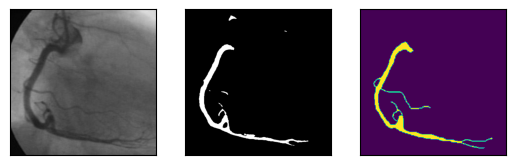

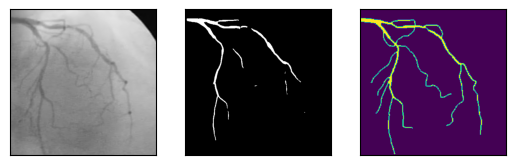

In [22]:
i = 5
orig = outputs_test[i][1].cpu().reshape(3,512,512).numpy().transpose(1,2,0)
label = outputs_test[i][3].cpu().reshape(512,512)
recon = outputs_test[i][2].cpu()
preds = torch.argmax(recon.squeeze(), dim=0).detach().cpu().numpy()
img = decode_segmap(preds)
i=2
orig3 = outputs_test[i][1].cpu().reshape(3,512,512).numpy().transpose(1,2,0)
recon3 = outputs_test[i][2].cpu()
preds3 = torch.argmax(recon3.squeeze(), dim=0).detach().cpu().numpy() 
label3 = outputs_test[i][3].cpu().reshape(512,512)
img3 = decode_segmap(preds3)

show([orig,img,label])
show([orig3,img3,label3])

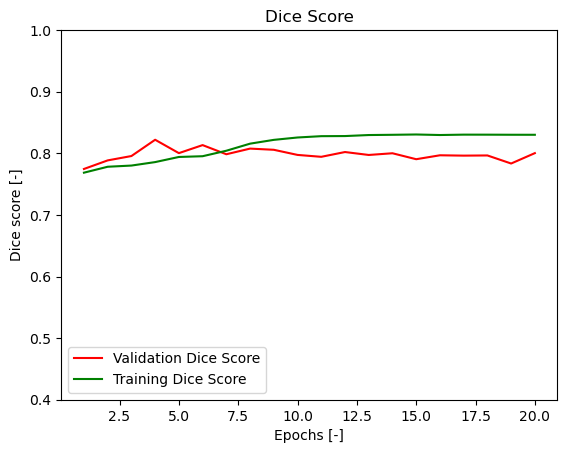

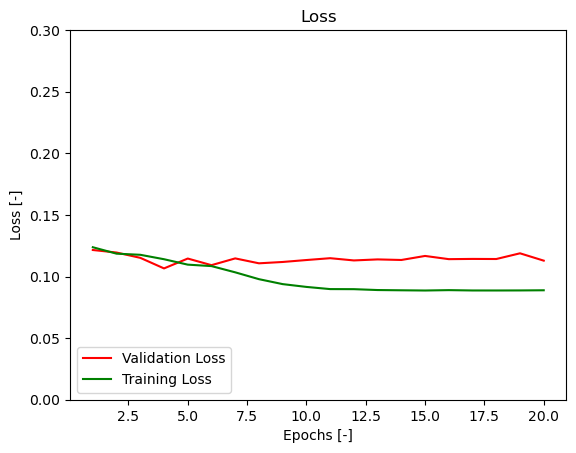

In [20]:
x = np.array(range(1,len(outputs)+1))
y = np.zeros(len(outputs))
y2 =np.zeros(len(outputs))

for i in range(0,len(outputs)):
    y[i] = outputs_val[i][2]
    y2[i] = outputs[i][2]
plt.title("Dice Score")
plt.plot(x, y, color="red", label="Validation Dice Score")
plt.plot(x, y2, 'g', label="Training Dice Score") 
plt.ylim([0.4, 1])
plt.xlabel("Epochs [-]")
plt.ylabel("Dice score [-]")
plt.legend(loc="lower left")

plt.show()

for i in range(0,len(outputs)):
    y[i] = outputs_val[i][1]
    y2[i] = outputs[i][1]

plt.title("Loss")
plt.plot(x, y, color="red", label="Validation Loss")
plt.plot(x, y2, 'g', label="Training Loss") 
plt.ylim([0, 0.3])
plt.legend(loc="lower left")

plt.xlabel("Epochs [-]")
plt.ylabel("Loss [-]")

plt.show()

In [27]:
torch.save(Model.state_dict(), 'model.pth')